$$

    f(a) = e^{-\int_0^a{(1+\epsilon(a, s))\mu(s) ds}}\\
    \mu(s) = \mu_{ub} - (\mu_{ub} - \mu_{lb})\frac{s^{m}}{s^{m} + K^{m}}

$$

$$
\epsilon(a, s) = 
\begin{cases}
    0 & \text{if } s < a - t_e \\
    g(a)e^{-\lambda(t_e-(a-s))} & \text{otherwise }
\end{cases}
$$

$$
\epsilon_0 e^{-\tau|a-t_e|}
$$

In [ ]:
from firm_dynamics.survival_analysis import prepare_df
import pandas as pd

df = prepare_df()

df_analysis = df.copy()

# Add age column
df_analysis['age'] = ((pd.to_datetime("2023-01-01")) - df_analysis['Entry Date']).dt.days / 365.25

# Add dead column
df_analysis['Dead'] = 1 - df_analysis['status']

# Drop ages > 30
df_analysis = df_analysis[df_analysis['age'] <= 30]

df_analysis.head()

,uen,Sector,status,Exit Date,Entry Date,Region,age,Dead
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,NR,4.963723,1
1,53290857X,S,1,NaT,2015-02-26 12:02:44,CR,7.843943,0
3,200412424K,G,1,NaT,2004-09-28 17:56:29,WR,18.255989,0
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,CR,3.723477,1
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,NER,29.722108,1


In [4]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13771959172635478, 0.06036883390826407, 9.683527817633134, 37.16554776246212], 
    [0.10853423852842373, 0.06040203094166163, 10.324655252053779, 20.2431022135619], 
    [0.08284949629045338, 0.07532170024242305, 7.246072550255881, 99.9995683704219], 
    [0.13138419047680286, 0.06388417019228498, 9.027011437441391, 63.20559648903392], 
    [0.07012004488933721, 0.011080713775644365, 17.599335895302804, 11.726782536983189], 
    [0.09997597066599069, 0.049270691945483475, 8.699132957275232, 100.0], 
    [0.19014425302275023, 0.02801565370451772, 6.937673733970917, 100.0], 
    [0.14057209547880267, 1.0000000076278874e-10, 12.954253262292541, 5.19908018295204], 
    [0.12396232834152839, 1e-10, 16.432702180468965, 3.6763918799521744], 
    [0.12639658719104133, 1.0000000249470075e-10, 20.851108767628933, 3.8694205399833757], 
    [0.1212132957507885, 0.06868421106599219, 9.445203344625348, 100.0], 
    [0.07305173006148806, 0.07305173006148806, 4.686889369376459, 49.86003240187913], 
    [0.07830160011697058, 0.047197607271208426, 7.792050676547918, 100.0], 
    [0.13228889671445893, 0.0854858990969846, 8.857658026221204, 100.0]
    ]
sector_params_MLE = dict(zip(sector_list, parameters))

In [6]:
from firm_dynamics.one_tail_dip import *
from firm_dynamics.hill import *
import matplotlib.pyplot as plt

def onetail_dip_model(df_analysis, sector_params_MLE, sector):
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)

    initial_guess = [0.1, 0.05, 10, 5, find_dip(df_analysis, sector), 3, 1, 0.1]

    result = mlefit_hill_with_dip(ages, survivors, totals, initial_guess)
    mu_ub, mu_lb, K, m, t_e, eps0, tau, lam = result.x
    print("Fitted parameters (with dip):")
    print(f"mu_ub: {mu_ub}, mu_lb: {mu_lb}, K: {K}, m: {m}, t_e: {t_e}, eps0: {eps0}, tau: {tau}, lam: {lam}")

    aic_original = 2 * 4 + 2 * neg_log_likelihood_hill(sector_params_MLE[sector], ages, survivors, totals)
    aic_with_dip = 2 * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
    print(f'AIC with dip = {aic_with_dip} \n AIC original = {aic_original}')
    bic_original = 2 * neg_log_likelihood_hill(sector_params_MLE[sector], ages, survivors, totals) + np.log(np.sum(totals)) * 4
    bic_with_dip = 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals) + np.log(np.sum(totals)) * 8
    print(f'BIC with dip = {bic_with_dip} \n BIC original = {bic_original}')

    plt.plot(ages, survival_fractions, 'o', markersize=3)
    plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam), label='with dip')
    plt.plot(ages, model_survival_curve_hill(ages, *sector_params_MLE[sector]), '--', label = 'original MLE fit')
    plt.title(f'Sector {sector} fit with dip')
    plt.legend()
    plt.show()

    return (aic_with_dip, aic_original), (bic_with_dip, bic_original)

--- Sector G ---
Fitted parameters (with dip):
mu_ub: 0.12726864194112503, mu_lb: 0.03807641459678071, K: 13.71120913748422, m: 4.4862513420005845, t_e: 8.25647560175015, eps0: 7.23507011659395, tau: 1.5283646874049974, lam: 1.5283646874049974
AIC with dip = 395465.4667404475 
 AIC original = 396597.3040134779
BIC with dip = 395552.8111123442 
 BIC original = 396640.9761994262


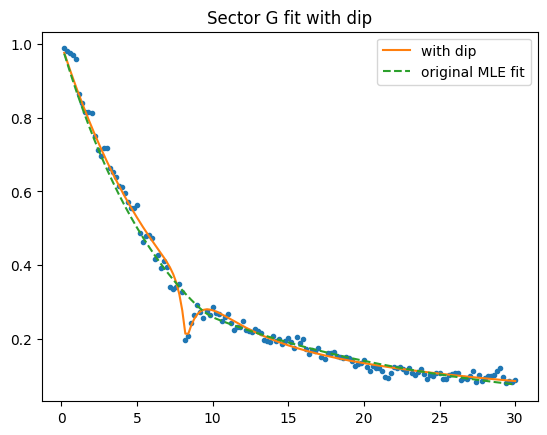

--- Sector H ---
Fitted parameters (with dip):
mu_ub: 0.08957383952818533, mu_lb: 0.001, K: 22.8314305439425, m: 22.749081288010935, t_e: 6.846661431150933, eps0: 2.3618809756875567, tau: 0.5997111550309087, lam: 1.0124037332474174e-05
AIC with dip = 83364.77346243674 
 AIC original = 85957.70099236167
BIC with dip = 83439.20382851208 
 BIC original = 85994.91617539934


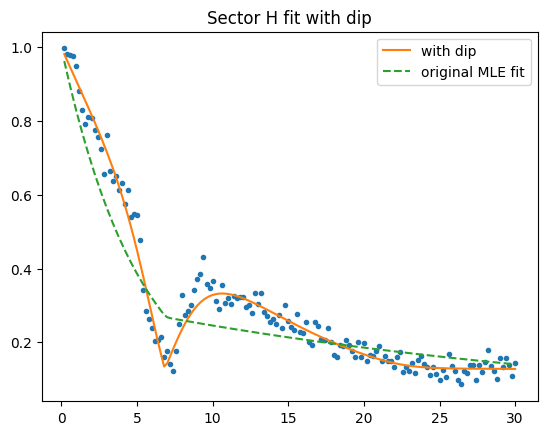

--- Sector S ---
Fitted parameters (with dip):
mu_ub: 0.13575945832518316, mu_lb: 0.00100000000004331, K: 13.471550710726323, m: 5.56094897605973, t_e: 8.27161565431276, eps0: 20.0, tau: 5.338904754844598, lam: 2.992999345020199
AIC with dip = 71390.04937605289 
 AIC original = 71512.57347341714
BIC with dip = 71463.32847012521 
 BIC original = 71549.2130204533


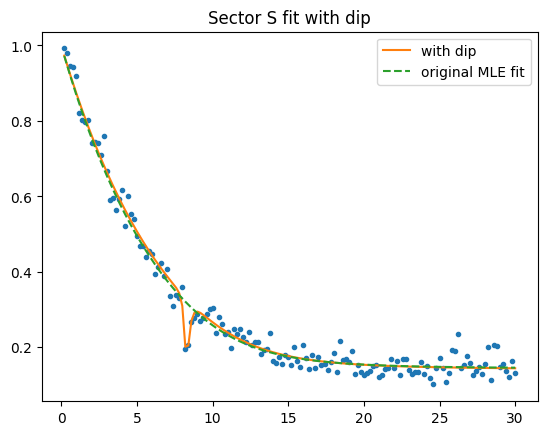

--- Sector J ---
Fitted parameters (with dip):
mu_ub: 0.12386920809591377, mu_lb: 0.05999938747915055, K: 10.708234222907398, m: 20.025989614607692, t_e: 4.539268793101835, eps0: 3.94807446311566, tau: 2.6186694273969437, lam: 1.2959522833249877
AIC with dip = 113661.75510107588 
 AIC original = 113961.26472763256
BIC with dip = 113738.60358550552 
 BIC original = 113999.68896984738


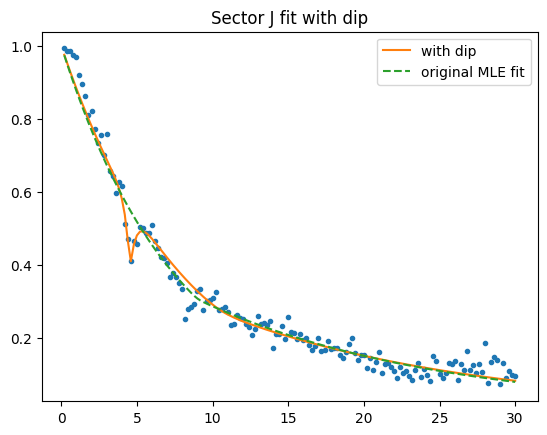

--- Sector M ---
Fitted parameters (with dip):
mu_ub: 0.08602912723274525, mu_lb: 0.001, K: 23.84464012789956, m: 18.818110188658686, t_e: 7.966494691738405, eps0: 0.9944906284146442, tau: 0.19651001121782555, lam: 0.1965100111983791
AIC with dip = 213206.91659917575 
 AIC original = 213792.9742091233
BIC with dip = 213288.44203742314 
 BIC original = 213833.73692824697


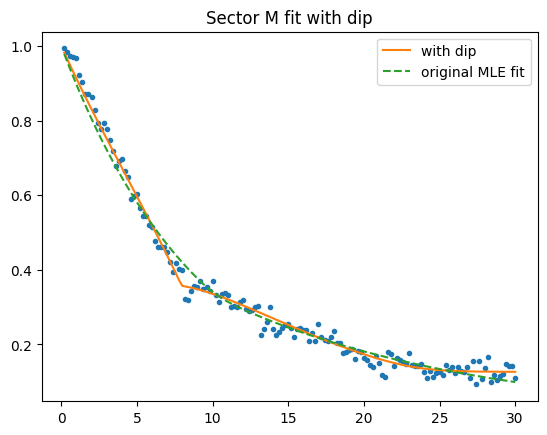

--- Sector I ---
Fitted parameters (with dip):
mu_ub: 0.124435319584067, mu_lb: 0.0010000000000000072, K: 20.894230527407018, m: 4.547079200816678, t_e: 5.199953232413778, eps0: 3.028887224422073, tau: 2.5726864703655052, lam: 2.5726864703655004
AIC with dip = 68490.03635116188 
 AIC original = 68503.12634688056
BIC with dip = 68563.24901116105 
 BIC original = 68539.73267688014


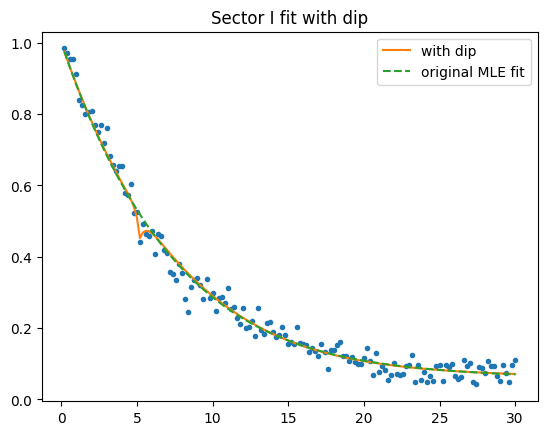

In [7]:
test_list = ['G', 'H', 'S', 'J', 'M', 'I']
aic_dip_list = []
aic_original_list = []
bic_dip_list = []
bic_original_list = []

for sector in test_list:
    print(f'--- Sector {sector} ---')
    aic, bic = onetail_dip_model(df_analysis, sector_params_MLE, sector)
    aic_dip_list.append(aic[0])
    aic_original_list.append(bic[1])  
    bic_dip_list.append(bic[0])
    bic_original_list.append(bic[1])  

In [8]:
aic_series = pd.Series(dict(zip(test_list, aic_dip_list)), index=test_list)
aic_original_series = pd.Series(dict(zip(test_list, aic_original_list)), index=test_list)
# Join the two series into a DataFrame
aic_df = pd.DataFrame({'AIC with Dip': aic_series, 'AIC Original': aic_original_series})
print(aic_df)

    AIC with Dip   AIC Original
G  395465.466740  396640.976199
H   83364.773462   85994.916175
S   71390.049376   71549.213020
J  113661.755101  113999.688970
M  213206.916599  213833.736928
I   68490.036351   68539.732677


In [9]:
bic_series = pd.Series(dict(zip(test_list, bic_dip_list)), index=test_list)
bic_original_series = pd.Series(dict(zip(test_list, bic_original_list)), index=test_list)
# Join the two series into a DataFrame
bic_df = pd.DataFrame({'BIC with Dip': bic_series, 'BIC Original': bic_original_series})
print(bic_df)

    BIC with Dip   BIC Original
G  395552.811112  396640.976199
H   83439.203829   85994.916175
S   71463.328470   71549.213020
J  113738.603586  113999.688970
M  213288.442037  213833.736928
I   68563.249011   68539.732677


--- Sector F ---
Fitted parameters (with dip):
mu_ub: 0.07758775241525354, mu_lb: 0.07758775142046728, K: 12.962010102564422, m: 2.4169909726840273, t_e: 5.379966009625431, eps0: 1.4757633354459083, tau: 1.1468262539878342, lam: 0.8757146546779027
AIC with dip = 95554.70272850509 
 AIC original = 95571.32745895388
BIC with dip = 95630.03897742166 
 BIC original = 95608.99558341216


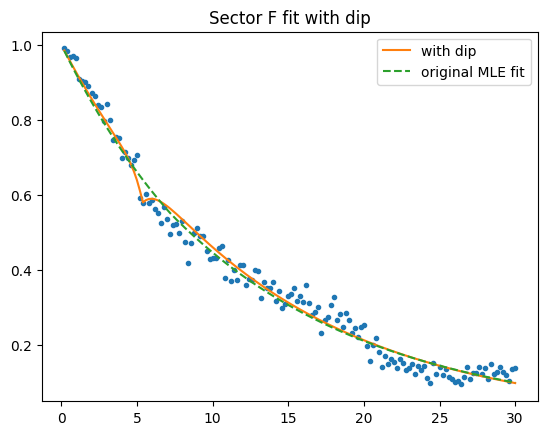

--- Sector P ---


c:\Users\chong\OneDrive\Documents\GitHub\a-star\firm_dynamics\one_tail_dip.py:26: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return g(a, eps0, tau, t_e)*np.exp(-lam*(t_e-(a-s)))


Fitted parameters (with dip):
mu_ub: 0.0887121228462275, mu_lb: 0.08871211584505052, K: 12.969166788178102, m: 0.5, t_e: 8.239774810848505, eps0: 0.9638251753537213, tau: 0.13557699225545305, lam: 0.13557699246658733
AIC with dip = 50220.202895297596 
 AIC original = 50319.80915009245
BIC with dip = 50290.30263063918 
 BIC original = 50354.859017763236


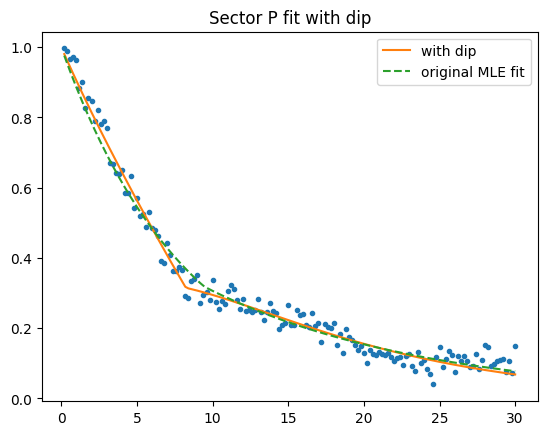

--- Sector K ---


c:\Users\chong\OneDrive\Documents\GitHub\a-star\firm_dynamics\one_tail_dip.py:26: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return g(a, eps0, tau, t_e)*np.exp(-lam*(t_e-(a-s)))


Fitted parameters (with dip):
mu_ub: 0.06633747495923505, mu_lb: 0.0010000000736666676, K: 20.09139759342859, m: 12.865350460735424, t_e: 7.677663296749926, eps0: 0.6964784050896804, tau: 0.37091607798312526, lam: 0.3709160989053461
AIC with dip = 112363.6502826821 
 AIC original = 112433.7547534963
BIC with dip = 112439.90551647064 
 BIC original = 112471.88237039057


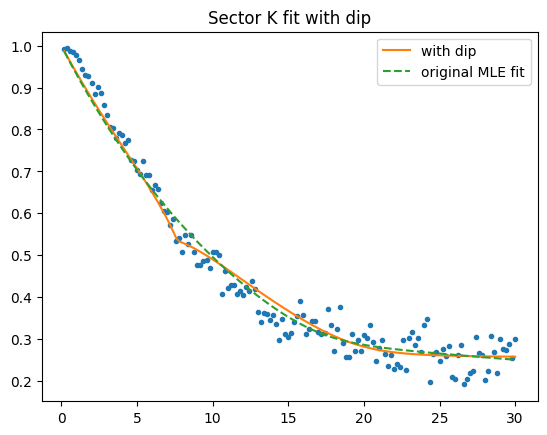

In [10]:
test_list = ['F', 'P', 'K']
aic_dip_list = []
aic_original_list = []
bic_dip_list = []
bic_original_list = []

for sector in test_list:
    print(f'--- Sector {sector} ---')
    aic, bic = onetail_dip_model(df_analysis, sector_params_MLE, sector)
    aic_dip_list.append(aic[0])
    aic_original_list.append(bic[1])
    bic_dip_list.append(bic[0])
    bic_original_list.append(bic[1])

In [11]:
aic_series = pd.Series(dict(zip(test_list, aic_dip_list)), index=test_list)
aic_original_series = pd.Series(dict(zip(test_list, aic_original_list)), index=test_list)
# Join the two series into a DataFrame
aic_df = pd.DataFrame({'AIC with Dip': aic_series, 'AIC Original': aic_original_series})
print(aic_df)

bic_series = pd.Series(dict(zip(test_list, bic_dip_list)), index=test_list)
bic_original_series = pd.Series(dict(zip(test_list, bic_original_list)), index=test_list)
# Join the two series into a DataFrame
bic_df = pd.DataFrame({'BIC with Dip': bic_series, 'BIC Original': bic_original_series})
print(bic_df)

    AIC with Dip   AIC Original
F   95554.702729   95608.995583
P   50220.202895   50354.859018
K  112363.650283  112471.882370
    BIC with Dip   BIC Original
F   95630.038977   95608.995583
P   50290.302631   50354.859018
K  112439.905516  112471.882370


In [ ]:
def epsilon(s, a, eps0, tau, lam, t_e):
    '''
    Time-dependent perturbation function
    Inputs:
    - s: integration variable (time)
    - a: age
    - eps0: amplitude of the perturbation
    - tau: decay rate (against age of firm) of the effect of external event
    - lam: recovery rate (against time since event)
    - t_e: time of event causing the perturbation
    '''
    def g(a, eps0, tau, t_e):
        if a < t_e:
            return eps0
        else:
            return eps0 * np.exp(-abs(a - t_e) * tau)
    if s < a - t_e:
        return 0
    else:
        return g(a, eps0, tau, t_e)*np.exp(-lam*(t_e-(a-s)))

def hill_survival_with_dip(a, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam):
    val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m) * epsilon(s, a, eps0, tau, lam, t_e), 0, a)
    return hill_survival_function(a, mu_ub, mu_lb, K, m) * np.exp(-val)

def model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam):
    return np.array([hill_survival_with_dip(a, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam) for a in ages])

def find_dip(df_analysis, sector):
    '''
    Find the dip location for a given sector by finding points of minimum log-likelihood
    '''
    sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
    parameters = [
    [0.13771959172635478, 0.06036883390826407, 9.683527817633134, 37.16554776246212], 
    [0.10853423852842373, 0.06040203094166163, 10.324655252053779, 20.2431022135619], 
    [0.08284949629045338, 0.07532170024242305, 7.246072550255881, 99.9995683704219], 
    [0.13138419047680286, 0.06388417019228498, 9.027011437441391, 63.20559648903392], 
    [0.07012004488933721, 0.011080713775644365, 17.599335895302804, 11.726782536983189], 
    [0.09997597066599069, 0.049270691945483475, 8.699132957275232, 100.0], 
    [0.19014425302275023, 0.02801565370451772, 6.937673733970917, 100.0], 
    [0.14057209547880267, 1.0000000076278874e-10, 12.954253262292541, 5.19908018295204], 
    [0.12396232834152839, 1e-10, 16.432702180468965, 3.6763918799521744], 
    [0.12639658719104133, 1.0000000249470075e-10, 20.851108767628933, 3.8694205399833757], 
    [0.1212132957507885, 0.06868421106599219, 9.445203344625348, 100.0], 
    [0.07305173006148806, 0.07305173006148806, 4.686889369376459, 49.86003240187913], 
    [0.07830160011697058, 0.047197607271208426, 7.792050676547918, 100.0], 
    [0.13228889671445893, 0.0854858990969846, 8.857658026221204, 100.0]
    ]
    sector_params_MLE = dict(zip(sector_list, parameters))

    _, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)

    mu_ub, mu_lb, K, m = sector_params_MLE[sector]
    S_vals = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = survivors * np.log(S_vals) + deaths * np.log(1 - S_vals)

    minlogL_ages = ages[np.argsort(logL)[:9]]
    max_count = 0
    best_cluster = []

    for i in range(len(minlogL_ages)):
        # Find all points within window of minlogL_ages[i]
        cluster = minlogL_ages[(minlogL_ages >= minlogL_ages[i]) & (minlogL_ages <= minlogL_ages[i] + 0.5)]
        if len(cluster) > max_count:
            max_count = len(cluster)
            best_cluster = cluster

    return float(np.mean(best_cluster)) if len(best_cluster) > 0 else None

def neg_ll_hill_with_dip(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m, t_e, eps0, tau, lam = params
    ll = 0
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0 or t_e < 0 or eps0 < 0 or tau <= 0 or lam <= 0:
        return np.inf

    S_vals = model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL  # minimize negative log-likelihood

def mlefit_hill_with_dip(ages, survivors, totals, initial_guess=[0.1, 0.05, 10, 5, 7, 1, 1, 1]):
    '''
    Fit the Hill model with dip using MLE.
    '''
    bounds = [
        (0.01, 0.3),   # mu_ub
        (10e-6, 0.15),   # mu_lb
        (0.1, 30),     # K
        (0.5, 50),    # m
        (3, 10),      # t_e
        (0, 20),    # eps0
        (0.01, 15),      # tau
        (10e-6, 15)      # lam
    ]

    constraints = [
        {'type': 'ineq', 'fun': lambda x: x[0] - x[1]},  # mu_ub - mu_lb > 0
        {'type': 'ineq', 'fun': lambda x: x[6] - x[7]},  # tau - lam > 0
    ]

    result = minimize(
        neg_ll_hill_with_dip,
        initial_guess,
        args=(ages, survivors, totals),
        bounds=bounds,
        constraints=constraints
    )

    return result

def onetail_dip_model(df_analysis, sector_params_MLE, sector):
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)

    initial_guess = [0.1, 0.03, 10, 5, find_dip(df_analysis, sector), 3, 1, 1]

    result = mlefit_hill_with_dip(ages, survivors, totals, initial_guess)
    mu_ub, mu_lb, K, m, t_e, eps0, tau, lam = result.x
    print("Fitted parameters (with dip):")
    print(f"mu_ub: {mu_ub}, mu_lb: {mu_lb}, K: {K}, m: {m}, t_e: {t_e}, eps0: {eps0}, tau: {tau}, lam: {lam}")

    aic_original = 2 * 4 + 2 * neg_log_likelihood_hill(sector_params_MLE[sector], ages, survivors, totals)
    aic_with_dip = 2 * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
    print(f'AIC with dip = {aic_with_dip} \n AIC original = {aic_original}')
    bic_original = 2 * 4 + np.log(len(ages) * len(survivors)) * 4 + 2 * neg_log_likelihood_hill(sector_params_MLE[sector], ages, survivors, totals)
    bic_with_dip = 2 * 8 + np.log(len(ages) * len(survivors)) * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
    print(f'BIC with dip = {bic_with_dip} \n BIC original = {bic_original}')

    plt.plot(ages, survival_fractions, 'o', markersize=3)
    plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam), label='with dip')
    plt.plot(ages, model_survival_curve_hill(ages, *sector_params_MLE[sector]), '--', label = 'original MLE fit')
    plt.title(f'Sector {sector} fit with dip')
    plt.legend()
    plt.show()

    return (aic_with_dip, aic_original), (bic_with_dip, bic_original)

--- Sector G ---
Fitted parameters (with dip):
mu_ub: 0.12726864194112503, mu_lb: 0.03807641459678071, K: 13.71120913748422, m: 4.4862513420005845, t_e: 8.25647560175015, eps0: 7.23507011659395, tau: 1.5283646874049974, lam: 1.5283646874049974
AIC with dip = 395465.4667404475 
 AIC original = 396597.3040134779
BIC with dip = 395552.8111123442 
 BIC original = 396640.9761994262


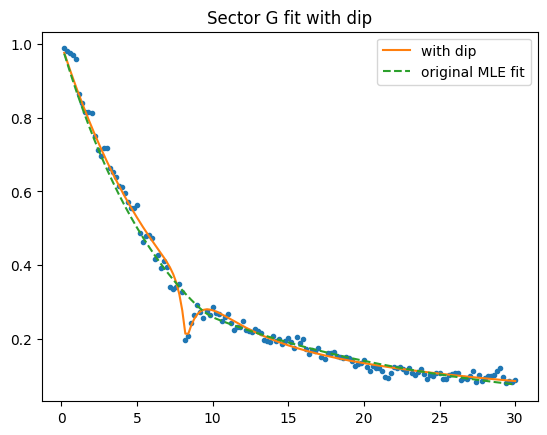

--- Sector M ---
Fitted parameters (with dip):
mu_ub: 0.08602912723274525, mu_lb: 0.001, K: 23.84464012789956, m: 18.818110188658686, t_e: 7.966494691738405, eps0: 0.9944906284146442, tau: 0.19651001121782555, lam: 0.1965100111983791
AIC with dip = 213206.91659917575 
 AIC original = 213792.9742091233
BIC with dip = 213288.44203742314 
 BIC original = 213833.73692824697


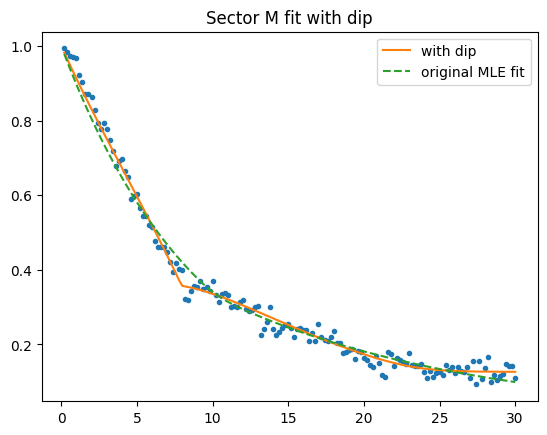

--- Sector F ---
Fitted parameters (with dip):
mu_ub: 0.07758775241525354, mu_lb: 0.07758775142046728, K: 12.962010102564422, m: 2.4169909726840273, t_e: 5.379966009625431, eps0: 1.4757633354459083, tau: 1.1468262539878342, lam: 0.8757146546779027
AIC with dip = 95554.70272850509 
 AIC original = 95571.32745895388
BIC with dip = 95630.03897742166 
 BIC original = 95608.99558341216


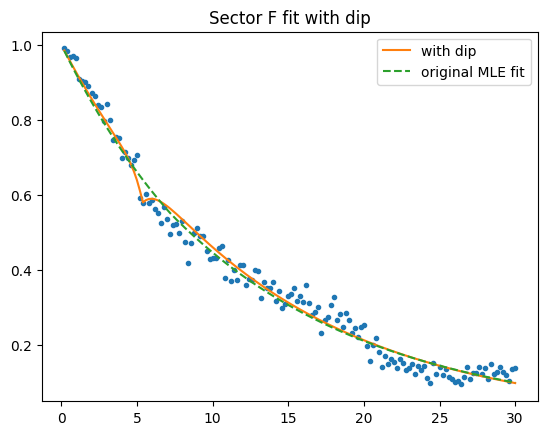

--- Sector J ---
Fitted parameters (with dip):
mu_ub: 0.12386920809591377, mu_lb: 0.05999938747915055, K: 10.708234222907398, m: 20.025989614607692, t_e: 4.539268793101835, eps0: 3.94807446311566, tau: 2.6186694273969437, lam: 1.2959522833249877
AIC with dip = 113661.75510107588 
 AIC original = 113961.26472763256
BIC with dip = 113738.60358550552 
 BIC original = 113999.68896984738


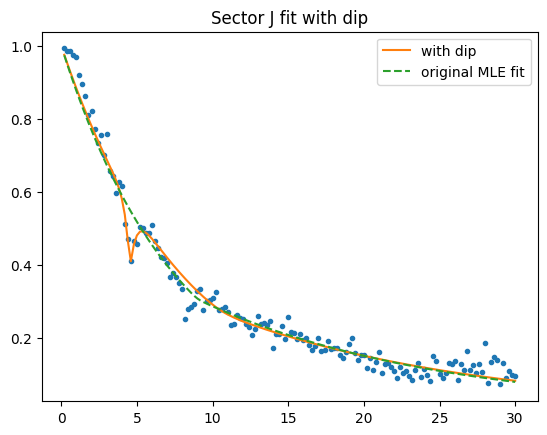

--- Sector K ---


c:\Users\chong\OneDrive\Documents\GitHub\a-star\firm_dynamics\one_tail_dip.py:26: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return g(a, eps0, tau, t_e)*np.exp(-lam*(t_e-(a-s)))


Fitted parameters (with dip):
mu_ub: 0.06633747495923505, mu_lb: 0.0010000000736666676, K: 20.09139759342859, m: 12.865350460735424, t_e: 7.677663296749926, eps0: 0.6964784050896804, tau: 0.37091607798312526, lam: 0.3709160989053461
AIC with dip = 112363.6502826821 
 AIC original = 112433.7547534963
BIC with dip = 112439.90551647064 
 BIC original = 112471.88237039057


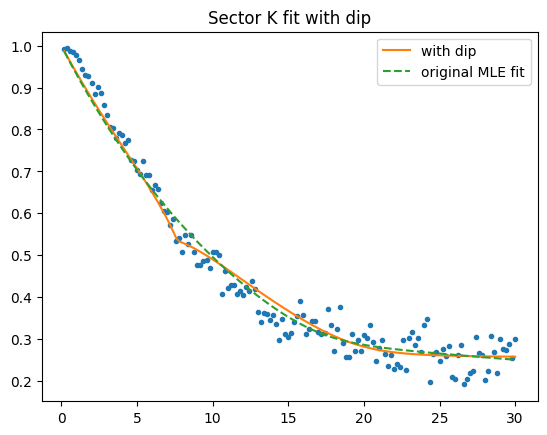

--- Sector C ---
Fitted parameters (with dip):
mu_ub: 0.06339724280053938, mu_lb: 0.06339724280053938, K: 10.349531746060112, m: 47.99156503496584, t_e: 8.245341003708216, eps0: 0.8574979927226856, tau: 0.08004005725596156, lam: 0.040417861119278045
AIC with dip = 79040.36228480013 
 AIC original = 79079.07595998689
BIC with dip = 79113.78112337446 
 BIC original = 79115.78537927405


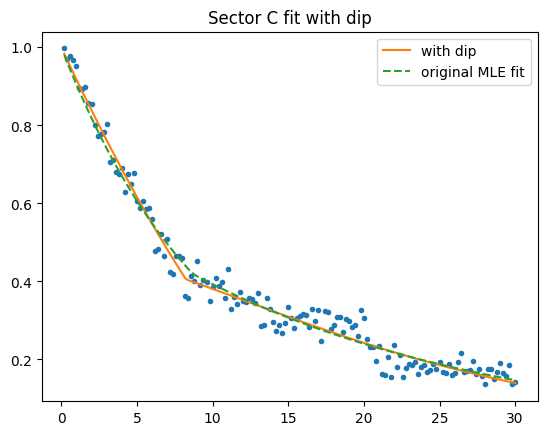

--- Sector H ---
Fitted parameters (with dip):
mu_ub: 0.08957383952818533, mu_lb: 0.001, K: 22.8314305439425, m: 22.749081288010935, t_e: 6.846661431150933, eps0: 2.3618809756875567, tau: 0.5997111550309087, lam: 1.0124037332474174e-05
AIC with dip = 83364.77346243674 
 AIC original = 85957.70099236167
BIC with dip = 83439.20382851208 
 BIC original = 85994.91617539934


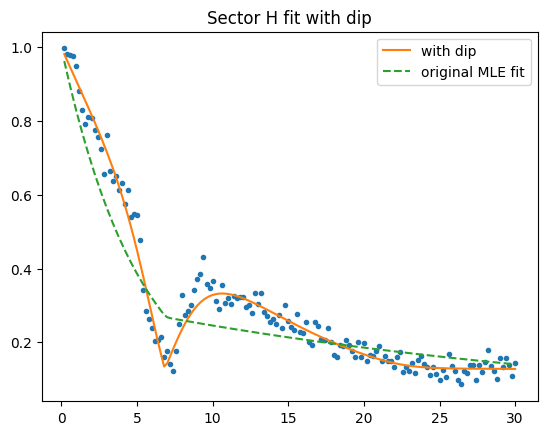

--- Sector S ---
Fitted parameters (with dip):
mu_ub: 0.13575945832518316, mu_lb: 0.00100000000004331, K: 13.471550710726323, m: 5.56094897605973, t_e: 8.27161565431276, eps0: 20.0, tau: 5.338904754844598, lam: 2.992999345020199
AIC with dip = 71390.04937605289 
 AIC original = 71512.57347341714
BIC with dip = 71463.32847012521 
 BIC original = 71549.2130204533


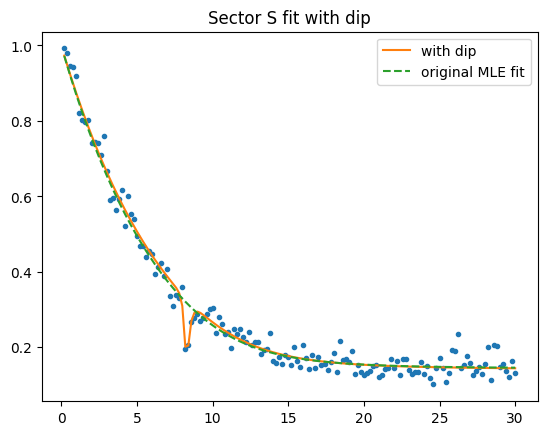

--- Sector N ---
Fitted parameters (with dip):
mu_ub: 0.11208650420691163, mu_lb: 0.0010000002533575262, K: 18.39601854442301, m: 6.916431440592437, t_e: 8.295105649564801, eps0: 0.4946037194581071, tau: 1.345892496439929, lam: 1.0000192231837247e-05
AIC with dip = 73858.84413920363 
 AIC original = 74032.64426434244
BIC with dip = 73932.36493672669 
 BIC original = 74069.40466310397


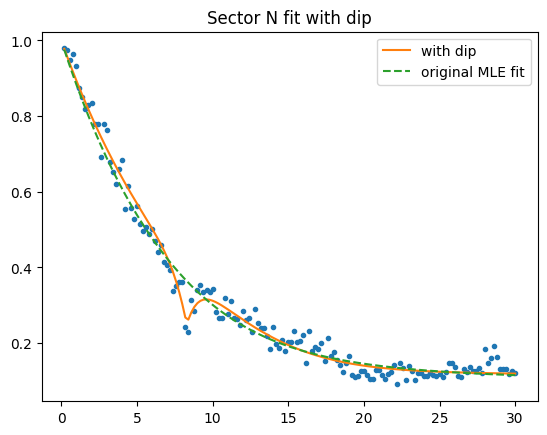

--- Sector I ---
Fitted parameters (with dip):
mu_ub: 0.124435319584067, mu_lb: 0.0010000000000000072, K: 20.894230527407018, m: 4.547079200816678, t_e: 5.199953232413778, eps0: 3.028887224422073, tau: 2.5726864703655052, lam: 2.5726864703655004
AIC with dip = 68490.03635116188 
 AIC original = 68503.12634688056
BIC with dip = 68563.24901116105 
 BIC original = 68539.73267688014


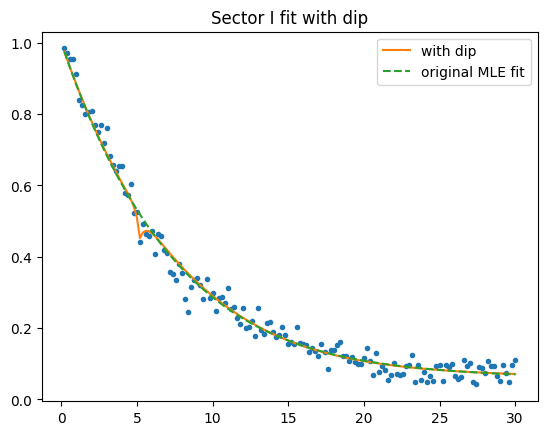

--- Sector P ---


c:\Users\chong\OneDrive\Documents\GitHub\a-star\firm_dynamics\one_tail_dip.py:26: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return g(a, eps0, tau, t_e)*np.exp(-lam*(t_e-(a-s)))


Fitted parameters (with dip):
mu_ub: 0.0887121228462275, mu_lb: 0.08871211584505052, K: 12.969166788178102, m: 0.5, t_e: 8.239774810848505, eps0: 0.9638251753537213, tau: 0.13557699225545305, lam: 0.13557699246658733
AIC with dip = 50220.202895297596 
 AIC original = 50319.80915009245
BIC with dip = 50290.30263063918 
 BIC original = 50354.859017763236


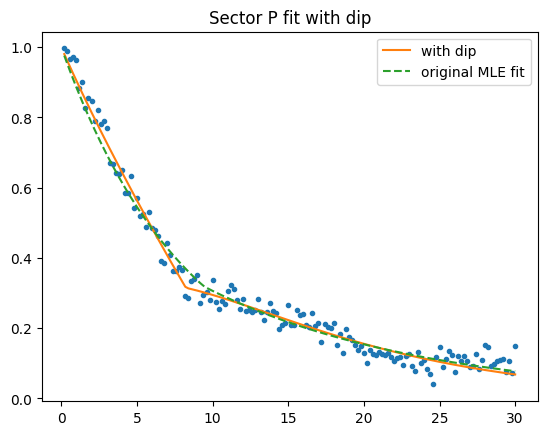

--- Sector L ---
Fitted parameters (with dip):
mu_ub: 0.07193515463955881, mu_lb: 0.0719351416206577, K: 13.156137138014616, m: 4.436652598416815, t_e: 7.162090839217494, eps0: 4.086512039136414, tau: 1.5282382343909837, lam: 1.094012470684829
AIC with dip = 23852.25005581067 
 AIC original = 23866.308678079025
BIC with dip = 23916.313196705796 
 BIC original = 23898.34024852659


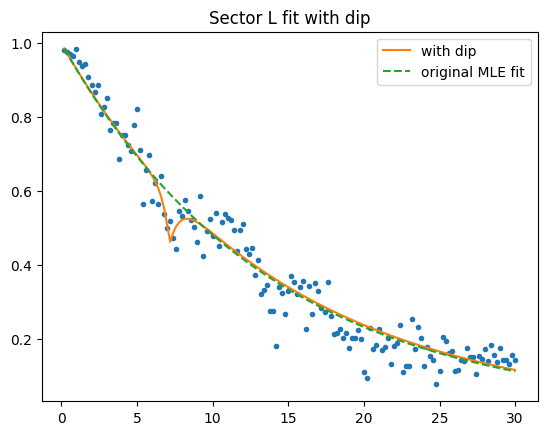

--- Sector Q ---
Fitted parameters (with dip):
mu_ub: 0.07746012364866833, mu_lb: 0.04936311857062731, K: 7.094956284650523, m: 50.0, t_e: 8.518514674331335, eps0: 4.832907605437462, tau: 4.2385819964032025, lam: 1.258418628535973
AIC with dip = 25774.963161160893 
 AIC original = 25785.16168086943
BIC with dip = 25838.8690989081 
 BIC original = 25817.114649743035


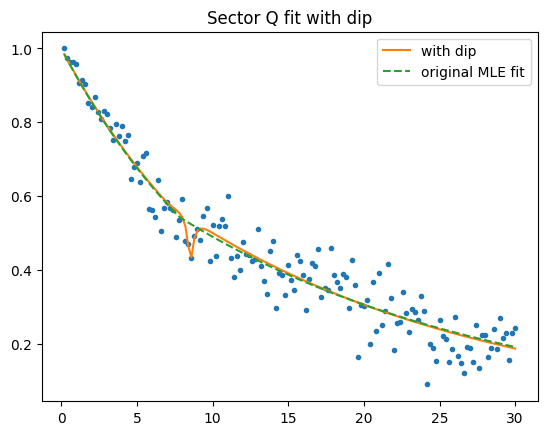

--- Sector R ---
Fitted parameters (with dip):
mu_ub: 0.12763576354996226, mu_lb: 0.08653953087680005, K: 9.589957023486743, m: 50.0, t_e: 4.29274627407802, eps0: 0.556432224274547, tau: 2.0654452095395124, lam: 0.13549365549066072
AIC with dip = 15040.106367838853 
 AIC original = 15047.29190333227
BIC with dip = 15101.570092334268 
 BIC original = 15078.023765579977


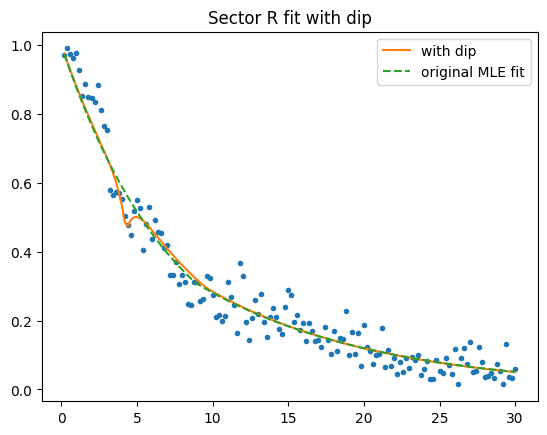

In [13]:
# test_list = ['G', 'H', 'S', 'J', 'M', 'I']
aic_dip_list = []
aic_original_list = []
bic_dip_list = []
bic_original_list = []

for sector in sector_list:
    print(f'--- Sector {sector} ---')
    aic, bic = onetail_dip_model(df_analysis, sector_params_MLE, sector)
    aic_dip_list.append(aic[0])
    aic_original_list.append(bic[1])  
    bic_dip_list.append(bic[0])
    bic_original_list.append(bic[1])

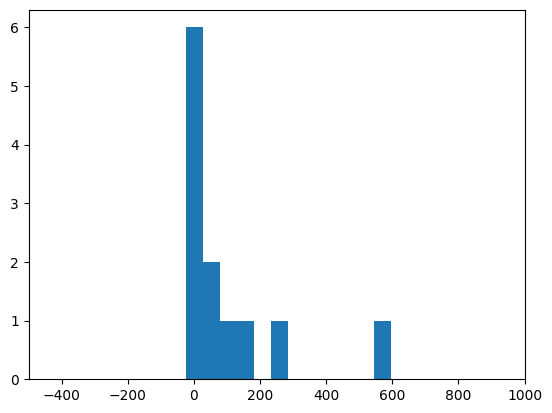

   Sector     AIC diff     BIC diff
0       G  1175.509459  1088.165087
1       M   626.820329   545.294891
2       F    54.292855   -21.043394
3       J   337.933869   261.085384
4       K   108.232088    31.976854
5       C    75.423094     2.004256
6       H  2630.142713  2555.712347
7       S   159.163644    85.884550
8       N   210.560524   137.039726
9       I    49.696326   -23.516334
10      P   134.656122    64.556387
11      L    46.090193   -17.972948
12      Q    42.151489   -21.754449
13      R    37.917398   -23.546327


In [14]:
diff_list = np.array(bic_original_list)-np.array(bic_dip_list)
plt.hist(diff_list, bins=50, label='BIC difference')
plt.xlim(-500, 1000)
plt.show()

table = pd.DataFrame({
    'Sector': sector_list,
    'AIC diff': np.array(aic_original_list) - np.array(aic_dip_list),
    'BIC diff': np.array(bic_original_list) - np.array(bic_dip_list)
})
print(table)

# J v.s. K
# S is the cut-off, exception of K

c:\Users\chong\OneDrive\Documents\GitHub\a-star\firm_dynamics\one_tail_dip.py:26: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return g(a, eps0, tau, t_e)*np.exp(-lam*(t_e-(a-s)))
c:\Users\chong\OneDrive\Documents\GitHub\a-star\firm_dynamics\one_tail_dip.py:26: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return g(a, eps0, tau, t_e)*np.exp(-lam*(t_e-(a-s)))
c:\Users\chong\OneDrive\Documents\GitHub\a-star\firm_dynamics\one_tail_dip.py:26: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It

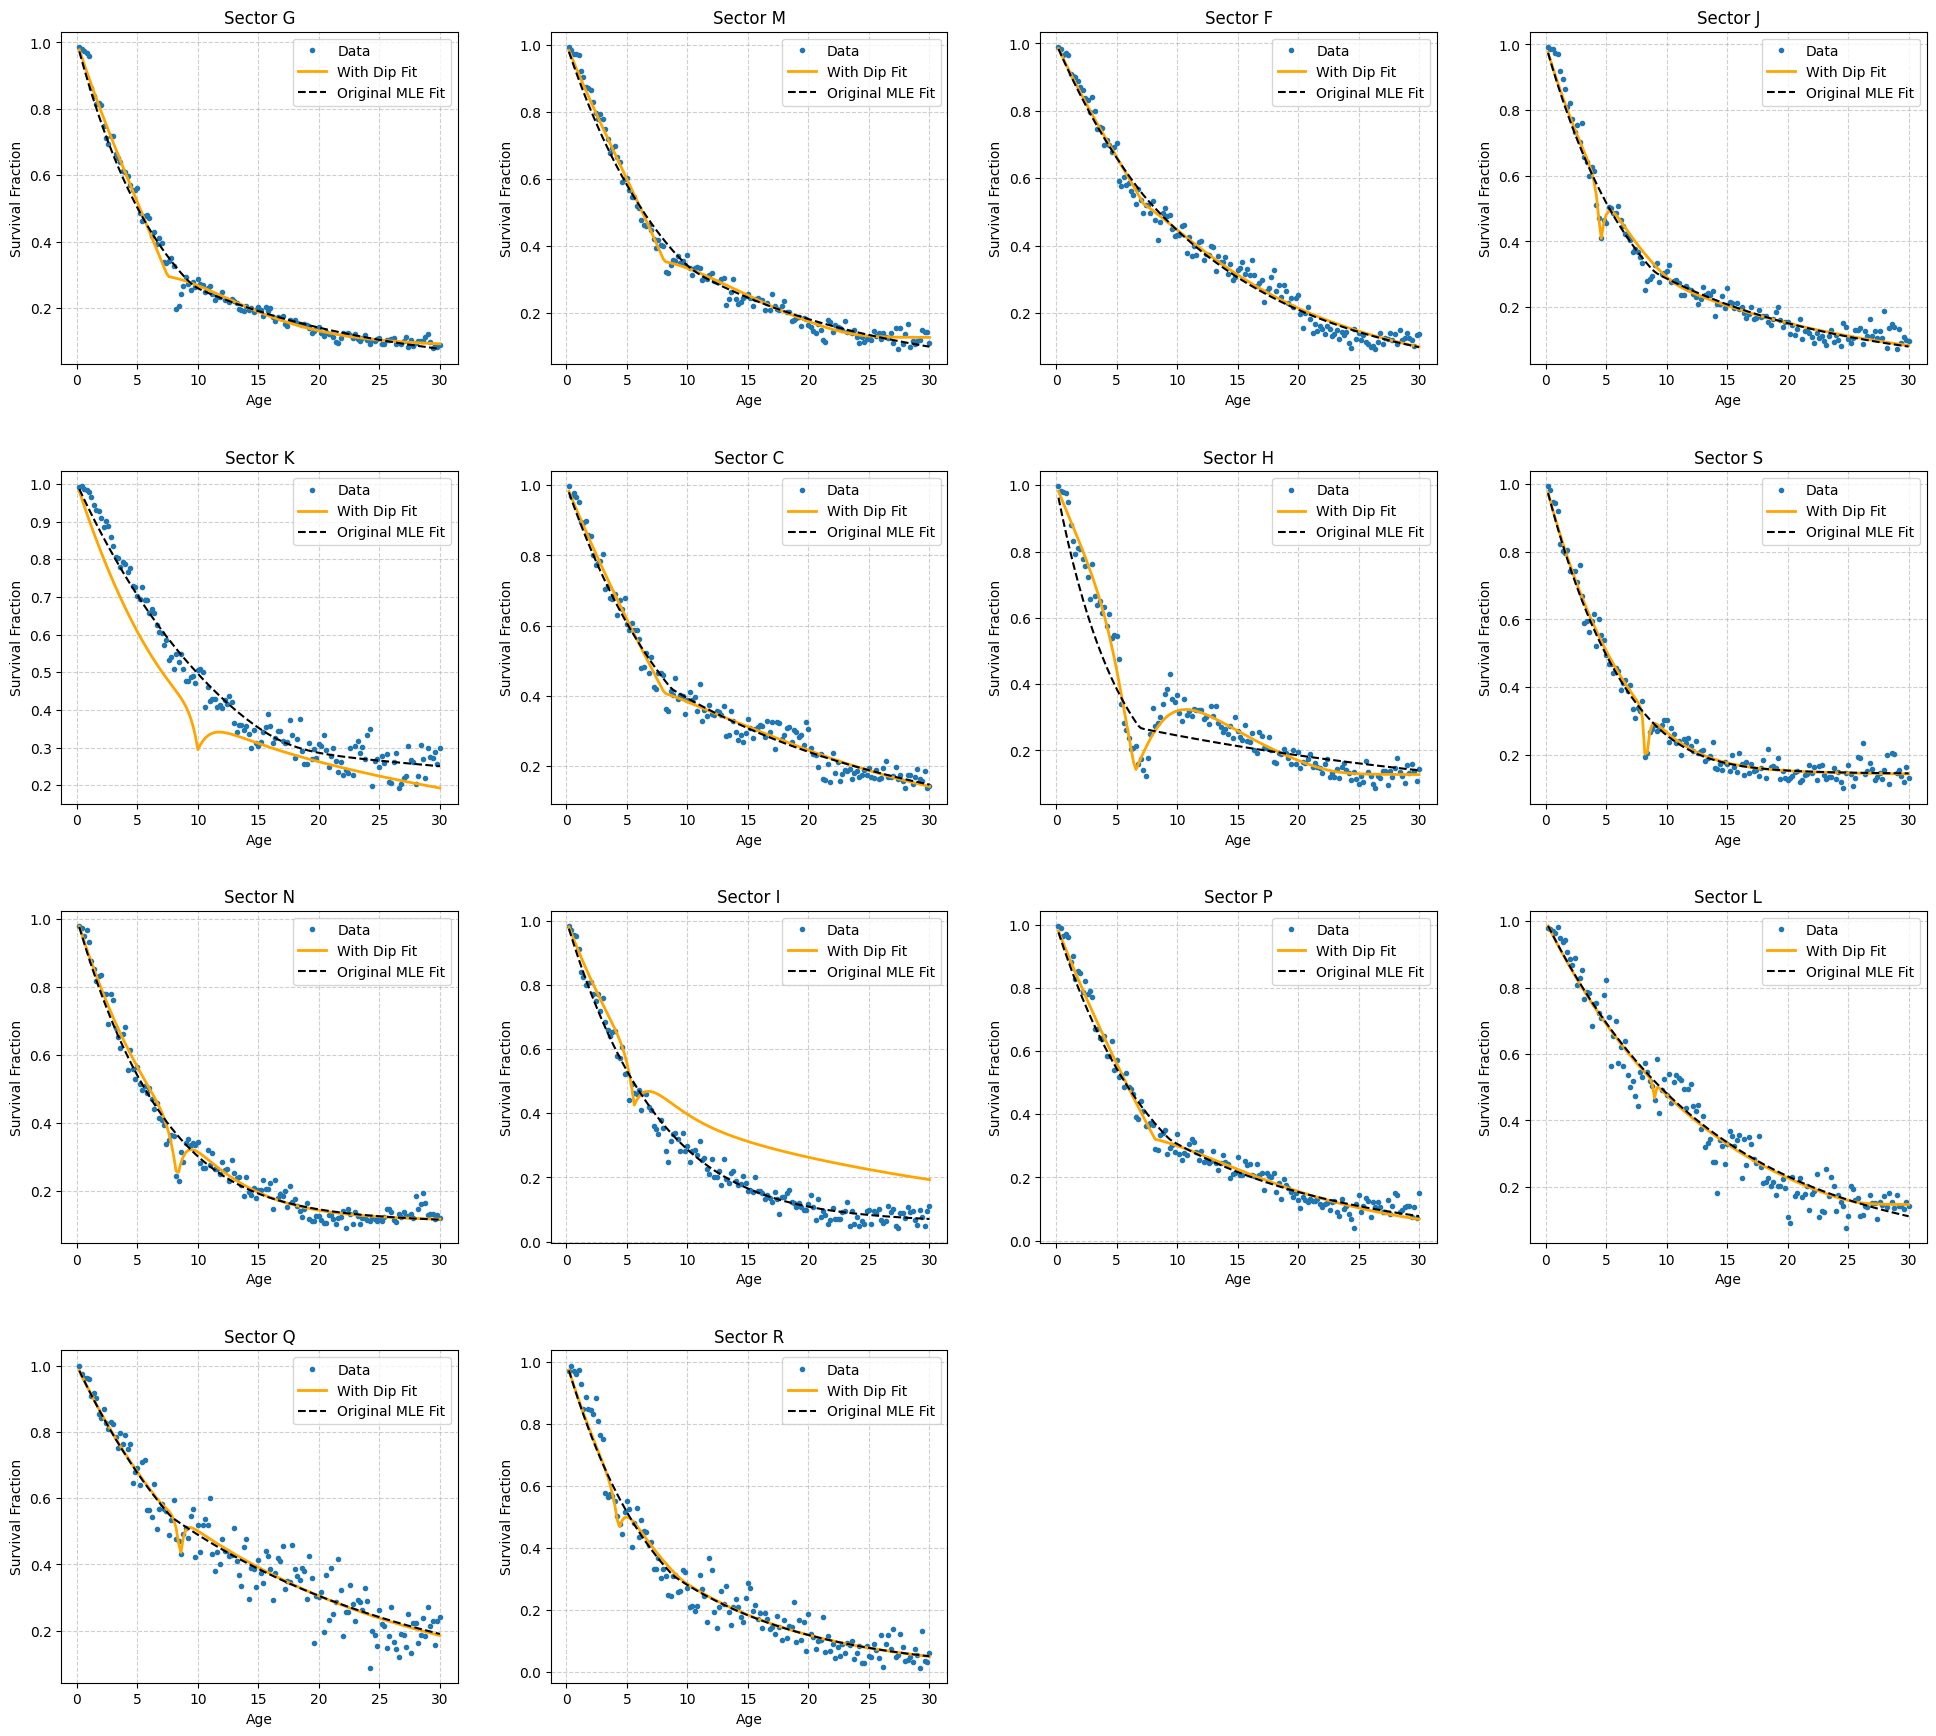

In [ ]:
def plot_sectors(df_analysis, sector_params_MLE, all_sectors):
    """
    Calculates and plots the survival curve fits for all specified sectors 
    on a single figure with multiple subplots.

    Args:
        df_analysis: The DataFrame containing the survival data.
        sector_params_MLE: A dictionary containing the original MLE parameters for each sector.
        all_sectors: A list of all sector identifiers to be plotted.
    """
    # Create a grid of subplots. A 4x4 grid is suitable for 14 sectors.
    fig, axes = plt.subplots(4, 4, figsize=(20, 18))
    # Flatten the 2D array of axes to make it easier to iterate over
    axes = axes.flatten()

    for i, sector in enumerate(all_sectors):
        ax = axes[i] # Get the current subplot axis

        try:
            # --- Data Extraction and Model Fitting (from your original function) ---
            survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
            totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)

            # Define initial guess for the optimization
            initial_guess = [0.1, 0.03, 10, 5, find_dip(df_analysis, sector), 3, 1, 1]

            # Perform the MLE fit for the model with a dip
            result = mlefit_hill_with_dip(ages, survivors, totals, initial_guess)
            mu_ub, mu_lb, K, m, t_e, eps0, tau, lam = result.x

            # --- Plotting on the Subplot ---
            # Plot the raw survival data points
            ax.plot(ages, survival_fractions, 'o', markersize=3, label='Data')
            
            # Plot the fitted model with the dip
            ax.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam), 
                    label='With Dip Fit', color='orange', linewidth=2)
            
            # Plot the original MLE fit without the dip
            ax.plot(ages, model_survival_curve_hill(ages, *sector_params_MLE[sector]), 
                    '--', label='Original MLE Fit', color='black')
            
            ax.set_title(f'Sector {sector}')
            ax.set_xlabel('Age')
            ax.set_ylabel('Survival Fraction')
            ax.legend()
            ax.grid(True, linestyle='--', alpha=0.6)

        except Exception as e:
            # If fitting or plotting fails for a sector, print an error and leave the subplot blank
            print(f"Could not process Sector {sector}: {e}")
            ax.set_title(f'Sector {sector} - Error')
            ax.text(0.5, 0.5, 'Fit Failed', horizontalalignment='center', verticalalignment='center')


    # --- Figure Cleanup ---
    # Hide any unused subplots if the number of sectors is not a perfect square
    for j in range(len(all_sectors), len(axes)):
        axes[j].set_visible(False)

    # Adjust layout to prevent titles and labels from overlapping
    plt.tight_layout(pad=3.0)
    
    # Show the final combined plot
    plt.show()

plot_sectors(df_analysis, sector_params_MLE, sector_list)